In [1]:
!pip install torchmetrics
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 529 kB 31.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch 
torch.manual_seed(42)
import numpy as np 
import matplotlib.pyplot as plt 
from google.colab import files

from tqdm.notebook import tqdm
# Import the Images module from pillow

from PIL import Image
import numpy as np
import skimage
import os
from tqdm.notebook import tqdm
import random
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision import transforms 
from torchvision.transforms import InterpolationMode
from torch import nn
from torchsummary import summary
from torch.nn.modules.activation import LeakyReLU

from torchmetrics import PeakSignalNoiseRatio
from torchmetrics import StructuralSimilarityIndexMeasure
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# device = 'cuda' # used to transer images to device --> image = image.to(device)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 10

size = 128, 128
img_dir = '/content/drive/MyDrive/Denoising_GANs/test_images/'
im1 = Image.open('/content/drive/MyDrive/Denoising_GANs/data/00000001_000.png')

In [5]:
def reduce_size(image):
  im_resized = image.resize(size, Image.LANCZOS)
  return np.array(im_resized).reshape(1,*size)/255

In [6]:
import numpy as np
import os
from skimage.util import random_noise
import cv2

def noisy(noise_typ,image):
  if noise_typ == "gauss":
      row,col,ch= image.shape
      mean = 0
      var = 0.1
      sigma = var**1.4
      gauss = np.random.normal(mean,sigma,(row,col,ch))
      gauss = gauss.reshape(row,col,ch)
      noisy = image + gauss
      return noisy
  elif noise_typ == "poisson":
      vals = len(np.unique(image))
      vals = 2 ** np.ceil(np.log2(vals))
      noisy = np.random.poisson(image * vals) / float(vals)
      return noisy
  elif noise_typ =="speckle":
      row,col,ch = image.shape
      gauss = np.random.randn(row,col,ch)
      gauss = gauss.reshape(row,col,ch)        
      noisy = image + image * gauss/12
      return noisy

In [7]:
def create_testing_data(img_dir):
  real_images = []
  noisy_images = []
  for f in tqdm(os.listdir(img_dir)):
    if os.path.splitext(f)[1] not in ['.png', '.jpg', '.jpeg']:
      continue
    image = Image.open(img_dir + str(f))
    image = reduce_size(image)
    if len(image.shape)>3:
      continue
    real_images.append(image)
    noi = ["gauss", "poisson", "speckle"]
    random_noise = random.choice(noi)
    noisy_image = noisy(random_noise,image)
    #  = image + 0.05 * np.random.randn(*image.shape)
    noisy_images.append(noisy_image)
  return torch.tensor(real_images).double(), torch.tensor(noisy_images).double()


In [8]:
real_images, noisy_images = create_testing_data(img_dir)

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


In [9]:
# Defining the Generator Block
def get_gen_blockConv(in_channels, out_channels, kernel_size, stride, padding=0):
  model = nn.Sequential(
      # Convolution Layer
      nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
      # Batch Normalization
      nn.BatchNorm2d(out_channels),
      # PReLU Activation function
      nn.PReLU()
  )
  return model

# Defining the class of Generator Model

class Generator(nn.Module):

  def __init__(self):
    super(Generator, self).__init__()

    self.block1 = get_gen_blockConv(1, 16, (9,9), 1, padding='same')
    self.block2 = get_gen_blockConv(16, 32, (3,3), 1, padding='same')
    self.block3 = get_gen_blockConv(32, 64, (3,3), 1, padding='same')
    self.block4 = get_gen_blockConv(64, 128, (3,3), 1, padding='same')
    self.blockResConv = get_gen_blockConv(128, 128, (3,3), 1, padding='same')
    self.block5= get_gen_blockConv(128, 64, (3,3), 1, padding='same' )
    self.block6 = get_gen_blockConv(64, 32, (3,3), 1, padding='same' )
    self.block7 = get_gen_blockConv(32, 16, (3,3), 1, padding='same' )
    self.lastconv = get_gen_blockConv(16, 1, (9,9), 1, padding='same' )
    self.tanh = nn.Tanh()
    self.prelu = nn.PReLU()

  def resnet_forward(self, input):
    output = self.blockResConv(input)

    output = output + input
    output = self.prelu(output)
    return output

  def forward(self,noisy_image):
    # Down sampling
    conv1 = self.block1(noisy_image)
    conv2 = self.block2(conv1)
    conv3 = self.block3(conv2)
    conv4 = self.block4(conv3)

    # ResNet Function
    res1 = self.resnet_forward(conv4)
    res2 = self.resnet_forward(res1)
    res3 = self.resnet_forward(res2)

    # Up sampling
    T0 = transforms.Resize((32, 32), InterpolationMode.NEAREST)
    deconv0 = self.block5(T0(res3))
    T1 = transforms.Resize((64, 64), InterpolationMode.NEAREST)
    deconv1 = self.block6(T1(deconv0))
    T2 = transforms.Resize((128, 128), InterpolationMode.NEAREST)
    deconv2 = self.block7(T2(deconv1))
    deconv2 = deconv2 + conv1
    conv5 = self.lastconv(deconv2)
    conv5= self.tanh(conv5)
    output = conv5 + noisy_image

    return output

In [10]:
randomDenoiser = Generator()

optimrandomDenoiser= torch.optim.Adam(randomDenoiser.parameters(), lr=0.0002,betas=(0.5, 0.5) )

checkpoint = torch.load("/content/drive/MyDrive/Denoising_GANs/random/checkpoint_models_it_50.pth", map_location="cpu")
randomDenoiser.load_state_dict(checkpoint["Gen"])
optimrandomDenoiser.load_state_dict(checkpoint['Gen_opt'])
randomDenoiser.to(device)
randomDenoiser.eval()

Generator(
  (block1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(9, 9), stride=(1, 1), padding=same)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
  )
  (block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
  )
  (block3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
  )
  (block4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
  )
  (blockResConv): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), paddi

In [11]:
poissonDenoiser = Generator()

optimpoissonDenoiser= torch.optim.Adam(randomDenoiser.parameters(), lr=0.0002,betas=(0.5, 0.99) )

poissonCheckpoint = torch.load("/content/drive/MyDrive/Denoising_GANs/poisson/checkpoint_models_it_50.pth", map_location="cpu")
poissonDenoiser.load_state_dict(poissonCheckpoint["Gen"])
optimpoissonDenoiser.load_state_dict(poissonCheckpoint['Gen_opt'])
poissonDenoiser.to(device)
poissonDenoiser.eval()

Generator(
  (block1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(9, 9), stride=(1, 1), padding=same)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
  )
  (block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
  )
  (block3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
  )
  (block4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
  )
  (blockResConv): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), paddi

In [12]:
randomDenoiser.double()
poissonDenoiser.double()

Generator(
  (block1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(9, 9), stride=(1, 1), padding=same)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
  )
  (block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
  )
  (block3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
  )
  (block4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
  )
  (blockResConv): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), paddi

In [13]:
def show_tensor_images(tensor_img, num_images = 9, size=(1, 128, 128)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=3)
    plt.figure(figsize=(10,10))
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [14]:
# Functions defining Evaluation Metrics

def calculate_batch_psnr(fake_image,real_image):
    psnr = PeakSignalNoiseRatio().to(device)
    p = psnr(fake_image, real_image)
    return p

def calculate_batch_ssim(fake_image, real_image):
    ssim = StructuralSimilarityIndexMeasure().to(device)
    s = ssim(fake_image, real_image)
    return s

In [15]:
batch_size=10

a = torch.stack((real_images,noisy_images), axis=1)
a_loader = DataLoader(a, batch_size=batch_size, shuffle = True)
noisy_image_loader = DataLoader(noisy_images, batch_size=batch_size, shuffle = True)
dataiter = iter(a_loader)

batch = dataiter.next()

batch0 = batch[:,0].to(device)
batch1 = batch[:,1].to(device)

In [16]:
noisy_image = batch1.to(device)

randomGen = randomDenoiser(noisy_image)
poissonGen = poissonDenoiser(randomGen)

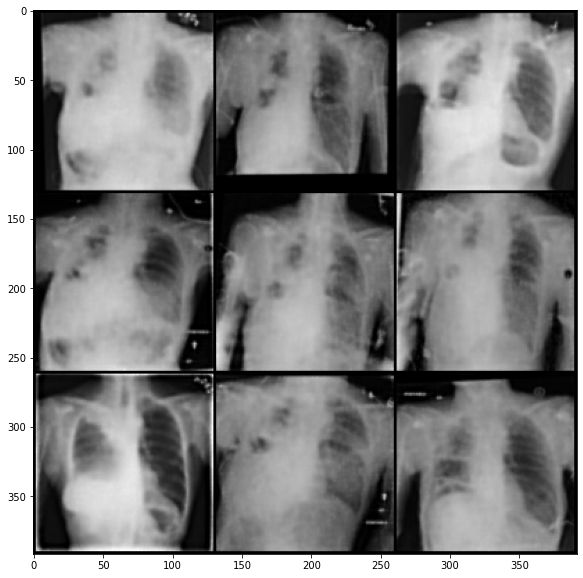

In [17]:
show_tensor_images(poissonGen)

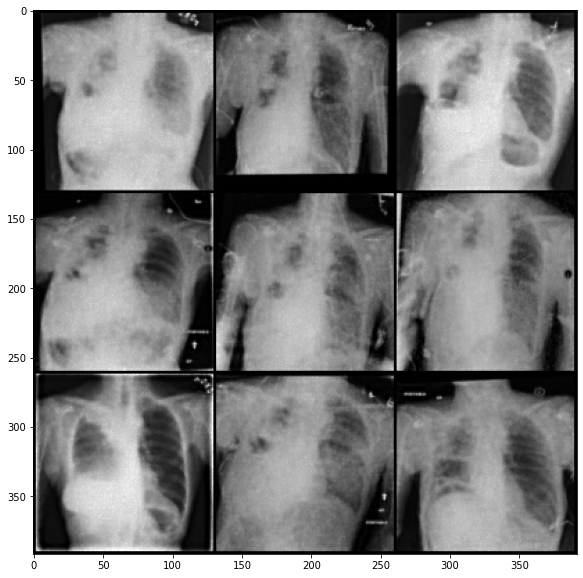

In [18]:
show_tensor_images(randomGen)

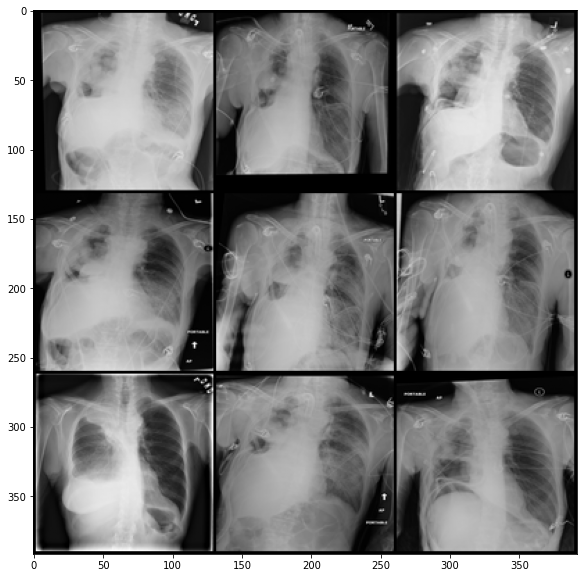

In [19]:
show_tensor_images(batch0)

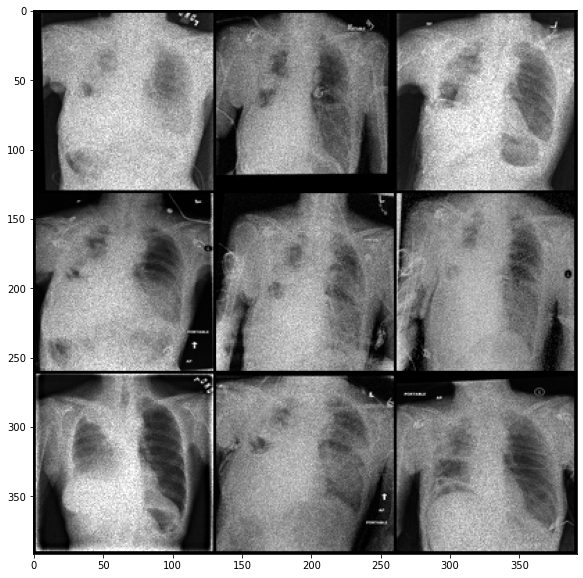

In [20]:
show_tensor_images(batch1)

In [21]:
fpass_psnr = calculate_batch_psnr(randomGen, batch0)
fpass_psnr

tensor(33.0198, device='cuda:0', dtype=torch.float64,
       grad_fn=<SqueezeBackward0>)

In [22]:
spass_psnr = calculate_batch_psnr(poissonGen, batch0)
spass_psnr

tensor(32.8366, device='cuda:0', dtype=torch.float64,
       grad_fn=<SqueezeBackward0>)

In [23]:
fpass_ssim = calculate_batch_ssim(randomGen, batch0)
fpass_ssim

tensor(0.8900, device='cuda:0', grad_fn=<SqueezeBackward0>)

In [24]:
spass_ssim = calculate_batch_ssim(poissonGen, batch0)
spass_ssim

tensor(0.9201, device='cuda:0', grad_fn=<SqueezeBackward0>)